## Part II: Feature Selection and Data Cleansing

#### Setup Environment

In [3]:
%run environment-setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [2]:
# import additional libs
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from scipy.stats import pointbiserialr

In [3]:
# Create database in Athena/Glue: set below flag to True if Db needs to be created, otherwise skip
CREATE_DB = False
if(CREATE_DB):
    wr.catalog.create_database(database_name)

In [4]:
# read from datalake (S3)
sepsis_df = wr.s3.read_csv(s3_datalake_path_csv + "/dataset.csv")
sepsis_ts_stats = wr.s3.read_csv(s3_datalake_path_csv + "/patient_ts_stats.csv")

2024-11-11 22:01:08,889	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 894435328 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.11gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-11-11 22:01:10,077	INFO worker.py:1786 -- Started a local Ray instance.


In [5]:
# conduct some basic cleaning of raw sepsis data for analysis
sepsis_df = sepsis_df.drop(columns=['Unnamed: 0'])

In [6]:
# check sparsity of clinical readings
sepsis_ts_stats['missing_clinicals'] = sepsis_ts_stats['num_time_steps'] - sepsis_ts_stats['total_clinicals']
sepsis_ts_stats['missing_clinicals_pct'] = sepsis_ts_stats['missing_clinicals'] / sepsis_ts_stats['num_time_steps']
sepsis_ts_stats = sepsis_ts_stats.drop(columns=['Unnamed: 0'])
sepsis_ts_stats

,patient_id,max_hour,max_adm_time,sepsis_label,num_time_steps,time_step_sepsis,time_step_clinicals_start,total_clinicals,time_step_labs_start,time_step_labs_last,total_labs,missing_clinicals,missing_clinicals_pct
0,17072,42,-0.02,0,43,-1,1,42,4,37,4,1,0.023256
1,16153,15,-0.04,0,16,-1,0,14,4,4,1,2,0.125000
2,465,35,-0.03,0,36,-1,1,32,13,24,2,4,0.111111
3,9891,35,-2.43,0,36,-1,1,35,7,25,6,1,0.027778
4,8065,45,-0.01,0,46,-1,1,44,1,43,6,2,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40331,104763,37,-2.74,0,38,-1,1,31,5,35,4,7,0.184211
40332,118556,14,-5.94,0,15,-1,1,10,1,12,11,5,0.333333
40333,105149,17,-4.09,0,18,-1,4,4,3,14,3,14,0.777778
40334,112699,16,-153.99,0,17,-1,1,14,2,15,6,3,0.176471


In [19]:
# write our raw patient data to parquet for use with Athena/Glue
wr.s3.to_parquet(
    sepsis_ts_stats, 
    path=f"{s3_datalake_path_parquet}/patient_stats", 
    dataset=True,
    database=database_name,
    table="patient_stats",
    filename_prefix="patient_stats"
)

{'paths': ['s3://sagemaker-us-east-1-343218227212/sepsis-prediction/parquet/patient_stats/patient_stats4168b98e334e4074bdc5e76a7a0119ba.snappy.parquet'],
 'partitions_values': {}}

### Feature Selection: Evaluate Feature Importance and Conduct Feature Selection on the Data

Based on EDA and domain expertise in the medical field, the features will be narrowed down to those deemed to those that are likely to influence Sepsis outcomes. 

 To support this selection, first a simple decision tree model will be trained on a summary of the dataset and feature importance will be evaluated.  In addition, a Point-biserial correlation coefficient (PBC) will be calculated for each continuous feature vs. our binary class.

In [7]:
# roll up the dataset to patien level, using avg value for each feature 
sepsis_patient_summary = sepsis_df.groupby(['Patient_ID']).mean()
sepsis_patient_summary.fillna(0, inplace=True)
sepsis_patient_summary = sepsis_patient_summary.reset_index()
sepsis_patient_summary['SepsisLabel'] = sepsis_patient_summary['SepsisLabel'].astype(int)
sepsis_patient_summary

,Patient_ID,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,1,26.5,101.571429,91.477273,36.778000,126.809524,87.261905,0.000000,24.820000,0.0,...,10.200000,0.0,327.500000,83.14,0.0,0.0,0.0,-0.03,27.5,0
1,2,11.0,60.954545,97.000000,36.165000,136.600000,66.704545,44.066667,14.236842,0.0,...,11.000000,0.0,158.000000,75.91,0.0,0.0,1.0,-98.60,12.0,0
2,3,23.5,79.611111,95.431818,37.609375,140.033333,81.048000,54.392857,25.633333,0.0,...,9.000000,0.0,479.666667,45.82,0.0,1.0,0.0,-1195.71,24.5,0
3,4,14.0,102.444444,98.203704,36.455000,113.019231,67.147308,51.428571,18.884615,0.0,...,7.600000,0.0,182.000000,65.71,0.0,0.0,1.0,-8.77,15.0,0
4,5,23.5,73.916667,97.500000,36.992222,132.770833,87.088235,0.000000,16.500000,0.0,...,6.933333,0.0,279.000000,28.09,1.0,1.0,0.0,-0.05,25.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40331,119996,23.5,89.456522,98.086957,36.400000,131.366667,84.602273,71.922222,19.176471,0.0,...,12.600000,0.0,238.000000,84.00,0.0,0.0,0.0,-6.69,24.5,0
40332,119997,12.0,61.062500,96.833333,36.800000,119.562500,90.937500,70.250000,20.384615,45.0,...,10.400000,0.0,189.000000,30.00,1.0,0.0,0.0,-0.02,13.0,0
40333,119998,24.0,80.202381,96.255814,36.733333,157.526316,116.157895,88.644737,20.578947,0.0,...,12.266667,0.0,197.333333,60.00,0.0,1.0,0.0,-53.64,25.0,0
40334,119999,9.5,94.333333,92.722222,37.620000,141.722222,100.833333,74.416667,21.666667,0.0,...,10.700000,0.0,263.500000,84.00,0.0,1.0,0.0,-10.74,10.5,0


In [7]:
# list all columns so we can evaluate what to include
cols = sepsis_patient_summary.columns.to_list()
for idx, col in enumerate(cols):
    print(f"{idx}: {col}")

0: Patient_ID
1: Hour
2: HR
3: O2Sat
4: Temp
5: SBP
6: MAP
7: DBP
8: Resp
9: EtCO2
10: BaseExcess
11: HCO3
12: FiO2
13: pH
14: PaCO2
15: SaO2
16: AST
17: BUN
18: Alkalinephos
19: Calcium
20: Chloride
21: Creatinine
22: Bilirubin_direct
23: Glucose
24: Lactate
25: Magnesium
26: Phosphate
27: Potassium
28: Bilirubin_total
29: TroponinI
30: Hct
31: Hgb
32: PTT
33: WBC
34: Fibrinogen
35: Platelets
36: Age
37: Gender
38: Unit1
39: Unit2
40: HospAdmTime
41: ICULOS
42: SepsisLabel


In [5]:
# separate input features from target - drop features that are time-series specfic from input
X_dt = sepsis_patient_summary.drop(columns=['SepsisLabel', 'Hour', 'ICULOS', 'HospAdmTime', 'Patient_ID'])
y_dt = sepsis_patient_summary['SepsisLabel']

In [6]:
# do some simple balancing of the target class
rus = RandomUnderSampler(random_state=42)
X_dt_resampled, y_dt_resampled = rus.fit_resample(X_dt, y_dt)

In [7]:
# Check class distribution after resampling
print('Resampled dataset shape %s' % Counter(y_dt_resampled))

Resampled dataset shape Counter({0: 426, 1: 426})


In [8]:
# Create a decision tree classifier
dt_clf = DecisionTreeClassifier()

# Fit the classifier to the data
dt_clf.fit(X_dt_resampled, y_dt_resampled)

# Access the feature importances
feature_importances = dt_clf.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_dt.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print(feature_importance_df)

             Feature  Importance
2               Temp    0.144244
33         Platelets    0.141420
31               WBC    0.076241
19        Creatinine    0.059778
1              O2Sat    0.057740
0                 HR    0.053542
21           Glucose    0.049105
3                SBP    0.040887
28               Hct    0.037757
15               BUN    0.035112
5                DBP    0.032779
34               Age    0.030040
27         TroponinI    0.024705
6               Resp    0.021679
18          Chloride    0.021352
4                MAP    0.018104
13              SaO2    0.016831
23         Magnesium    0.016756
36             Unit1    0.016559
8         BaseExcess    0.015560
26   Bilirubin_total    0.014560
25         Potassium    0.014132
12             PaCO2    0.011364
22           Lactate    0.009539
30               PTT    0.008472
14               AST    0.008469
9               HCO3    0.007147
24         Phosphate    0.006260
17           Calcium    0.005477
16      Al

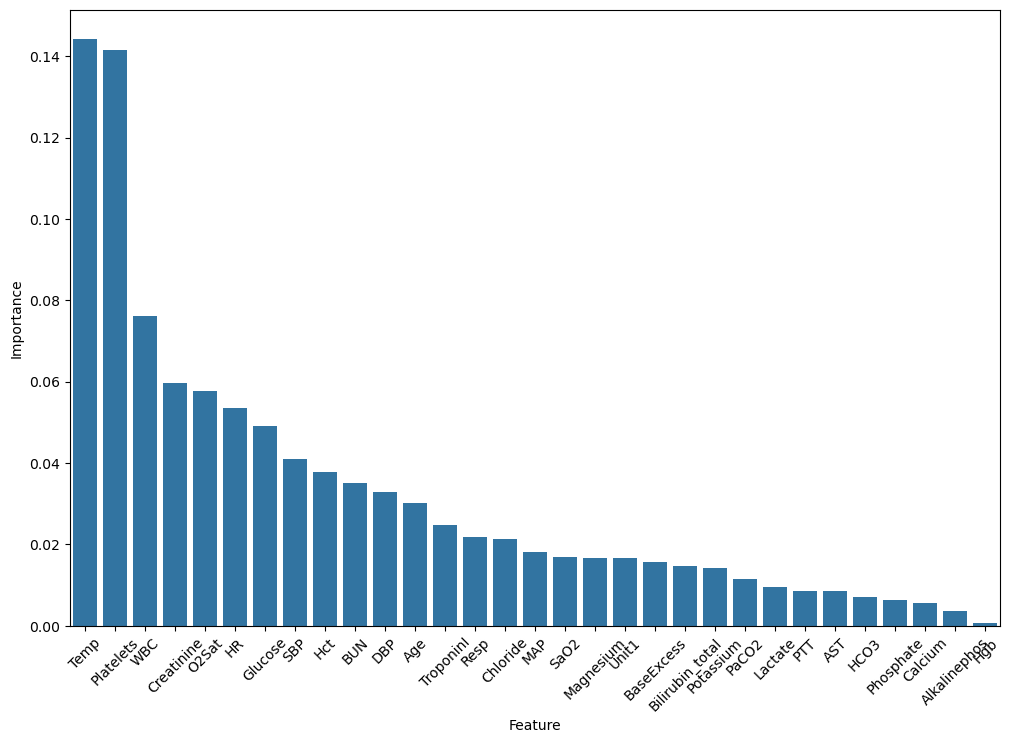

In [9]:
# plot the feature importance
important_features = feature_importance_df[feature_importance_df['Importance'] > 0]
plt.figure(figsize=(12,8))
sns.barplot(x=important_features['Feature'], y=important_features['Importance'])
plt.xticks(rotation=45)
plt.show()

#### Calculate Point-biserial correlation coefficient (PBC) for each continuous feature

In [57]:
# get the continuous columns
pbc_coefficients = []
sepsis_cont_vars = sepsis_patient_summary.iloc[:, 2:36]
sepsis_target = sepsis_patient_summary['SepsisLabel']
for idx, col in enumerate(sepsis_cont_vars.columns.to_list()):
    r_pb, p_value = pointbiserialr(sepsis_target, sepsis_cont_vars.iloc[:, idx])
    pbc_coefficients.append([col, r_pb, p_value])

pbc_coefficients_df = pd.DataFrame(data=pbc_coefficients, columns=['feature', 'pb', 'p_value'])

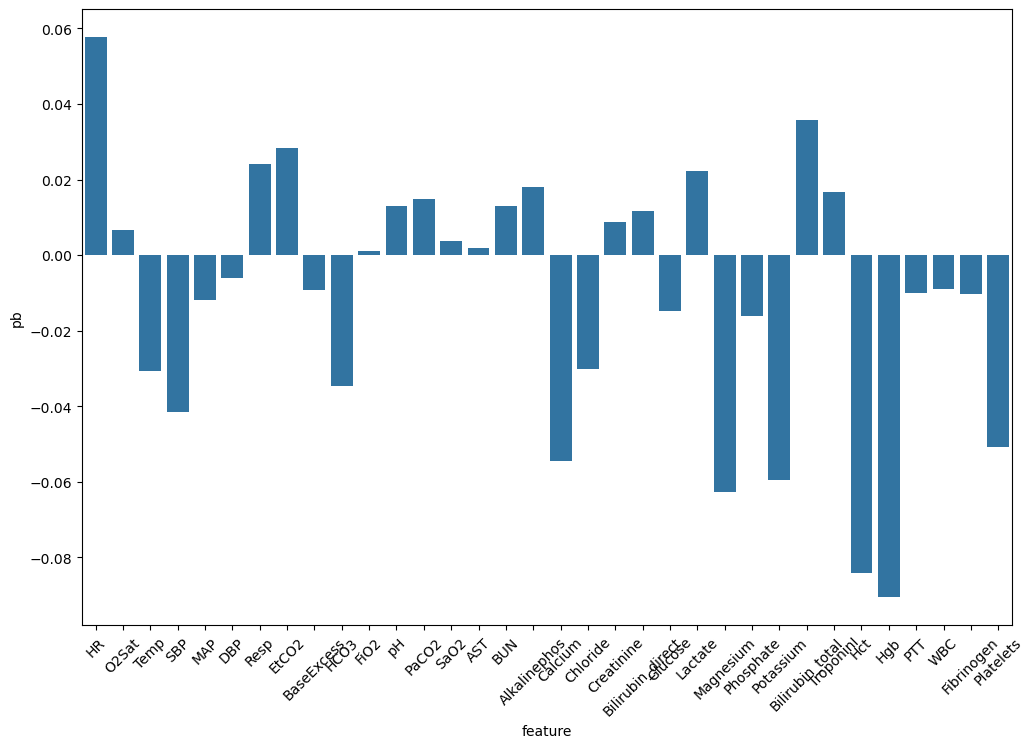

In [58]:
# plot the pbc
important_features = feature_importance_df[feature_importance_df['Importance'] > 0]
plt.figure(figsize=(12,8))
sns.barplot(x=pbc_coefficients_df['feature'], y=pbc_coefficients_df['pb'])
plt.xticks(rotation=45)
plt.show()

#### Observations

The feature importance generated from the simple decision tree classifier model show some support for the team's hypotheses of the features relevant to Sepsis prediction based on medical domain knowledge.  These are cross referenced with EDA information regarding how frequently these labs are collected.  Namely, the following:

* All vitals (Temp, HR, etc.)
* Platelets (92,209 non null)
* WBC/White Blood Count (99,447 non null)
* Creatinine (94,616 non null)
* Glucose (265,516 non null)
* Lactate (Possible ISSUE: only 41,446 non null)

Some interesting additions from the feature importance were observed.  These features showed importance and seemed to be part of regular lab samples, meaning they are typically available (based on EDA):

* HCT (137,433 non null)
* HGB (114,591 non null)
* BUN (106,568 non null)
* Potassium (144,525 non null)
* Magnesium (97,951 non null)
* Calcium (91,331 non null)
* Chloride (70,466 non null)
* pH (107,573 non null)

The Point-biserial correlation coefficient (PBC) provides a correlation factor between -1 and 1 (-1 = perfect negative correlation, 0=no correlation, 1=perfect positive correlation).  It is well suited for comparing continuous variables to binary outcomes.  While the calcluation does provide some insight into the variables, it should be taken with some qualification.  Namely, it is unclear how well this functions with the high occurance of NaN values in our dataset for the continuous variables.  In this case, we have imputed them to 0, which may even make things worse.  Due to this, more weight will be placed on the Feature Importance evaluation done using Decision Trees thank this correlation.


### Data Cleansing

Based on the analysis above, the feature selection will first be preformed selecting the features identified in our analysis as relevant to our modeling.  In addition, several data cleansing operations will be conducted.  In summary, the following steps will be taken:

1.  Execute the feature selection on the dataset
2.  Remove patients that do not have any lab samples, have sparse lab samples (from our selected features) or have too short time series
3.  Run imputation on our vital/clinical values
4.  Feature engineer our lab values (ie: convert to "last reading") and remove raw values

#### Feature Selection

In [ ]:
# capture chosen features for each
selected_feature_cols

In [9]:
# create feature selected dataset
sepsis_selected_df = sepsis_df[selected_feature_cols]
sepsis_selected_df

,Patient_ID,Hour,SepsisLabel,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,Lactate,Hct,BUN,Potassium,Magnesium,Calcium,Age,Gender,HospAdmTime,ICULOS
0,17072,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,1
1,17072,1,0,65.0,100.0,NaN,NaN,72.0,NaN,16.5,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,2
2,17072,2,0,78.0,100.0,NaN,NaN,42.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,3
3,17072,3,0,73.0,100.0,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,4
4,17072,4,0,70.0,100.0,NaN,129.0,74.0,69.0,14.0,...,NaN,29.7,23.0,3.2,1.6,9.6,68.54,0,-0.02,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,113911,21,0,83.0,99.0,NaN,121.0,77.0,54.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,88.00,0,-2.93,22
1552206,113911,22,0,80.0,92.0,NaN,102.0,73.0,51.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,88.00,0,-2.93,23
1552207,113911,23,0,95.0,97.0,36.7,128.5,83.0,58.5,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,88.00,0,-2.93,24
1552208,113911,24,0,104.0,99.0,NaN,127.0,85.0,59.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,88.00,0,-2.93,25


In [10]:
# write our feature selected patient data to parquet for use with Athena/Glue
wr.s3.to_parquet(
    sepsis_selected_df, 
    path=f"{s3_datalake_path_parquet}/sepsis_data_feature_select", 
    dataset=True,
    database=database_name,
    table="sepsis_data_feature_select",
    filename_prefix="sepsis_data_feature_select"
)

{'paths': ['s3://sagemaker-us-east-1-343218227212/sepsis-prediction/parquet/sepsis_data_feature_select/sepsis_data_feature_select8840b8f29f984f2fbfe7cb8b8a3ac814.snappy.parquet'],
 'partitions_values': {}}

#### Patient Selection/Filtering
This section will conduct two tasks to clean our dataset to select patients that have relatively complete data.  This will include enough timesteps to meet our lookback + time horizon sequence length that we will train our models on; and a relatively complete set of data across clinical and lab readings within this time horizon.

For the first step, our objective time horizon (PREDICTION_HORIZON) is to predict sepsis at least 6 hours before its first detection.  We will combine this with a lookback window to define the sequence length of our time series data (LOOKBACK_WINDOW).  As such will remove patients that do not have data for at least:

patient_time_series_length >= PREDICTION_HORIZON + LOOKBACK_WINDOW


Not all patients in our dataset have complete data, particularly for lab readings (our EDA revealed many with no readings) as well as sparse clinical/vital sign readings.  Based on our compiled patient statistics, we will drop patients that have either or both 

1. No labs were taken at any point for the patient
2. Clinical readings were very sparse


In [11]:
# set time series length minimum based on look back and prediction horizon
min_ts_length = PREDICTION_HORIZON + LOOKBACK_WINDOW

In [12]:
# query our stats data to filter patients with less than target sequence length
usable_patients = get_patient_ids_meets_data_threshold(min_ts_length, 0.3)

/tmp/ipykernel_6574/1035936457.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


In [13]:
# convert to list
patient_ids_with_time_series = usable_patients['patient_id'].to_list()

In [14]:
# query full ds for patients with sufficient time series
patients_with_ts_data = sepsis_selected_df[sepsis_selected_df['Patient_ID'].isin(patient_ids_with_time_series)]
patients_with_ts_data

,Patient_ID,Hour,SepsisLabel,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,Lactate,Hct,BUN,Potassium,Magnesium,Calcium,Age,Gender,HospAdmTime,ICULOS
0,17072,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,1
1,17072,1,0,65.0,100.0,NaN,NaN,72.0,NaN,16.5,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,2
2,17072,2,0,78.0,100.0,NaN,NaN,42.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,3
3,17072,3,0,73.0,100.0,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,4
4,17072,4,0,70.0,100.0,NaN,129.0,74.0,69.0,14.0,...,NaN,29.7,23.0,3.2,1.6,9.6,68.54,0,-0.02,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552129,104763,33,0,81.0,98.0,NaN,122.0,71.0,53.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,80.00,0,-2.74,34
1552130,104763,34,0,80.0,98.0,NaN,119.0,66.0,47.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,80.00,0,-2.74,35
1552131,104763,35,0,80.0,100.0,36.7,113.0,67.0,52.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,80.00,0,-2.74,36
1552132,104763,36,0,80.0,100.0,NaN,111.0,68.0,54.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,80.00,0,-2.74,37


#### Clean/Impuate Missing Data
This section will evaluate the features at a patient and time series level and impute the values.  This will be done as follows:

* For clinical/lab continuous variables, missing data will be filled with the "last reading" of the feature
* For lab variables, create a time lag index for each feature, which indicates the time since the last labs were taken
* For demographic data, patients with missing data will be dropped

In [15]:
# helper function to create lag features
def create_lag_features(df, feature_cols):
    # get all unique patients
    unique_patient_ids = df['Patient_ID'].unique()
    
    # create matrix for lag features 
    lag_features = np.zeros(shape=(patients_with_ts_data.shape[0], len(feature_cols)))
    lag_column_names = [x + '_lag' for x in feature_cols]
    lag_features_found = np.zeros(shape=len(feature_cols))
    
    # iterate patients
    row_counter = 0
    for patient_id in unique_patient_ids:
        patient_records = df[df['Patient_ID'] == patient_id].sort_values(by=['Hour'], ascending=True)
        patient_row_counter = 0
        for idx, patient_record in patient_records.iterrows():
            for col_idx, col in enumerate(feature_cols):
                if(np.isnan(patient_record[col])):
                    if(lag_features_found[col_idx] == 1 and (patient_row_counter > 0)):
                        lag_features[row_counter, col_idx] = lag_features[row_counter - 1, col_idx] + 1
                    else:
                        lag_features[row_counter, col_idx] = 99
                elif(not np.isnan(patient_record[col])):
                    lag_features_found[col_idx] = 1
            row_counter += 1
            patient_row_counter += 1

    return pd.concat([df, pd.DataFrame(index=df.index, data=lag_features, columns=lag_column_names)], axis=1)

In [16]:
# create the lag features
patient_df_with_lags = create_lag_features(patients_with_ts_data, lab_feature_cols)
patient_df_with_lags

,Patient_ID,Hour,SepsisLabel,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,WBC_lag,Platelets_lag,Creatinine_lag,Glucose_lag,Lactate_lag,Hct_lag,BUN_lag,Potassium_lag,Magnesium_lag,Calcium_lag
0,17072,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,17072,1,0,65.0,100.0,NaN,NaN,72.0,NaN,16.5,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
2,17072,2,0,78.0,100.0,NaN,NaN,42.5,NaN,NaN,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
3,17072,3,0,73.0,100.0,NaN,NaN,NaN,NaN,17.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
4,17072,4,0,70.0,100.0,NaN,129.0,74.0,69.0,14.0,...,0.0,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552129,104763,33,0,81.0,98.0,NaN,122.0,71.0,53.0,18.0,...,5.0,5.0,5.0,5.0,132.0,5.0,5.0,5.0,5.0,5.0
1552130,104763,34,0,80.0,98.0,NaN,119.0,66.0,47.0,17.0,...,6.0,6.0,6.0,6.0,133.0,6.0,6.0,6.0,6.0,6.0
1552131,104763,35,0,80.0,100.0,36.7,113.0,67.0,52.0,12.0,...,7.0,7.0,7.0,0.0,134.0,7.0,7.0,7.0,7.0,7.0
1552132,104763,36,0,80.0,100.0,NaN,111.0,68.0,54.0,16.0,...,8.0,8.0,8.0,1.0,135.0,8.0,8.0,8.0,8.0,8.0


In [17]:
# group the dataset by PatientID and forward fill the cont vars
patient_sepsis_data = patient_df_with_lags.copy()
cols = selected_feature_cols.copy()
cols.remove('Patient_ID')

# impute with ffill (fill values with last known reading)
patient_sepsis_data[['Patient_ID'] + cols] = patient_sepsis_data.groupby('Patient_ID')[selected_feature_cols].ffill()

# impute with bfill (fill values with first known reading)
patient_sepsis_data[['Patient_ID'] + cols] = patient_sepsis_data.groupby('Patient_ID')[selected_feature_cols].bfill()

# anything left that is nan, fill them in with the mean value of the column
patient_sepsis_data[['Patient_ID'] + cols] = patient_sepsis_data.groupby('Patient_ID')[selected_feature_cols].fillna(patient_sepsis_data.mean())

patient_sepsis_data.sort_values(by=['Patient_ID', 'Hour'])

/tmp/ipykernel_6574/207087869.py:13: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  patient_sepsis_data[['Patient_ID'] + cols] = patient_sepsis_data.groupby('Patient_ID')[selected_feature_cols].fillna(patient_sepsis_data.mean())


,Patient_ID,Hour,SepsisLabel,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,WBC_lag,Platelets_lag,Creatinine_lag,Glucose_lag,Lactate_lag,Hct_lag,BUN_lag,Potassium_lag,Magnesium_lag,Calcium_lag
132940,1,0,0,97.0,95.0,36.11,98.0,75.33,63.995019,19.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
132941,1,1,0,97.0,95.0,36.11,98.0,75.33,63.995019,19.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
132942,1,2,0,89.0,99.0,36.11,122.0,86.00,63.995019,22.0,...,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0
132943,1,3,0,90.0,95.0,36.11,122.0,86.00,63.995019,30.0,...,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0
132944,1,4,0,103.0,88.5,36.11,122.0,91.33,63.995019,24.5,...,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471604,120000,30,0,80.0,96.0,36.40,115.0,87.00,65.000000,15.0,...,11.0,11.0,11.0,2.0,129.0,11.0,11.0,11.0,11.0,11.0
1471605,120000,31,0,74.0,97.0,36.40,114.0,83.00,67.000000,15.0,...,12.0,12.0,12.0,3.0,130.0,12.0,12.0,12.0,12.0,12.0
1471606,120000,32,0,78.0,98.0,36.40,110.0,83.00,69.000000,15.0,...,13.0,13.0,13.0,4.0,131.0,13.0,13.0,13.0,13.0,13.0
1471607,120000,33,0,82.0,99.0,36.60,124.0,91.00,71.000000,16.0,...,14.0,14.0,14.0,0.0,132.0,14.0,14.0,14.0,14.0,14.0


In [18]:
# check for any remaining NA values
patient_sepsis_data.isnull().values.any()

False

In [19]:
# inspect a sample patient
patient_sepsis_data[patient_sepsis_data['Patient_ID'] == 1]

,Patient_ID,Hour,SepsisLabel,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,WBC_lag,Platelets_lag,Creatinine_lag,Glucose_lag,Lactate_lag,Hct_lag,BUN_lag,Potassium_lag,Magnesium_lag,Calcium_lag
132940,1,0,0,97.0,95.0,36.11,98.0,75.33,63.995019,19.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
132941,1,1,0,97.0,95.0,36.11,98.0,75.33,63.995019,19.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
132942,1,2,0,89.0,99.0,36.11,122.0,86.00,63.995019,22.0,...,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0
132943,1,3,0,90.0,95.0,36.11,122.0,86.00,63.995019,30.0,...,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0
132944,1,4,0,103.0,88.5,36.11,122.0,91.33,63.995019,24.5,...,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0
132945,1,5,0,110.0,91.0,36.11,122.0,91.33,63.995019,22.0,...,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0
132946,1,6,0,108.0,92.0,36.11,123.0,77.00,63.995019,29.0,...,105.0,105.0,105.0,105.0,105.0,105.0,105.0,105.0,105.0,105.0
132947,1,7,0,106.0,90.5,36.11,93.0,76.33,63.995019,29.0,...,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0
132948,1,8,0,104.0,95.0,36.11,133.0,88.33,63.995019,26.0,...,107.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0
132949,1,9,0,102.0,91.0,36.11,134.0,87.33,63.995019,30.0,...,108.0,108.0,108.0,108.0,108.0,108.0,108.0,108.0,108.0,108.0


In [20]:
# write our clean patient data to parquet for use with Athena/Glue
wr.s3.to_parquet(
    patient_sepsis_data, 
    path=f"{s3_datalake_path_parquet}/sepsis_data_clean", 
    dataset=True,
    database=database_name,
    table="sepsis_data_clean",
    mode='overwrite',
    index=False,
    filename_prefix="sepsis_data_clean"
)

{'paths': ['s3://sagemaker-us-east-1-343218227212/sepsis-prediction/parquet/sepsis_data_clean/sepsis_data_cleane26abdf793d54a9a88164721001a8a8e.snappy.parquet'],
 'partitions_values': {}}